In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import *
from darts.metrics import mae
from darts.ad import *

import os

In [2]:
def split_train_val(series, train_size: float = 0.75):
    train, val = series.split_before(train_size)

    fig, ax = plt.subplots(figsize=(30, 5))

    train.plot(label="training", ax=ax)
    val.plot(label="val", ax=ax)

    return train, val

In [3]:
def forecast_and_plot(model, series_train, series_val, multi=False):
    if multi:
        pred = model.predict(n=len(series_val), series=series_train)
    else:
        pred = model.predict(n=len(series_val))

    loss = mae(series_val, pred)
    print(f"model {model} obtains MAE: {loss}")
    fig, ax = plt.subplots(figsize=(30, 5))
    series_train.plot(label="train")
    series_val.plot(label="true")
    pred.plot(label="prediction")

    return loss

In [4]:
def historical_forecast_and_plot(model, series, forecast_horizon):
    pred = model.historical_forecasts(
        series, start=0.95, forecast_horizon=forecast_horizon, verbose=True
    )

    print("model {} obtains MAE: {:.2f}".format(model, mae(pred, series)))
    fig, ax = plt.subplots(figsize=(30, 5))
    series.plot(label="train")
    pred.plot(label="prediction")

In [5]:
def process_file(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df = df.resample("W").ffill()
    file_name = os.path.basename(file_path)
    base_name = os.path.splitext(file_name)[0]
    df.to_csv(f"data/processed/walmart_sales/bySD_fillDates/{base_name}.csv")


def process_files_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            process_file(file_path)

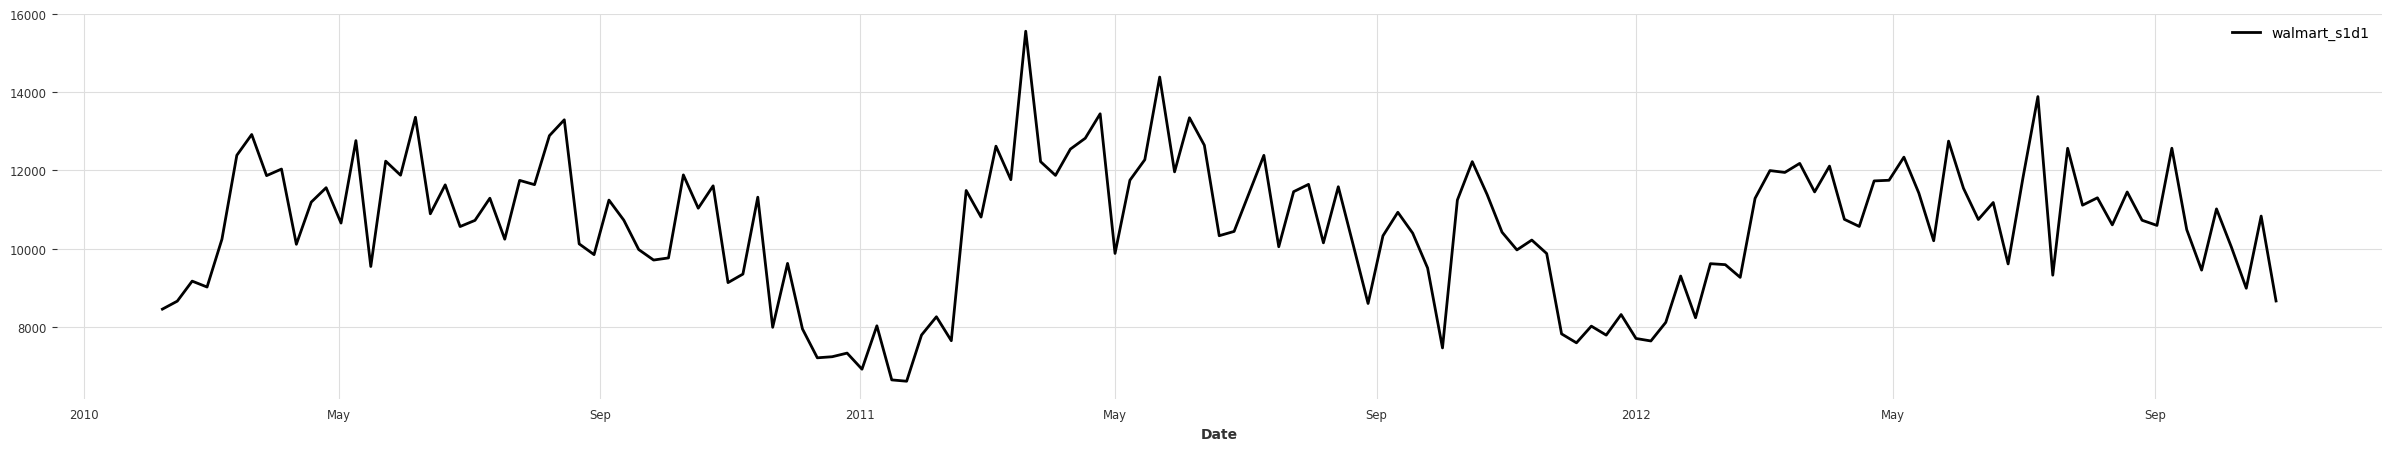

In [11]:
ts = TimeSeries.from_csv(
    "data/clean/walmart_sales/bySD/walmart_s1d12.csv",
    time_col="Date",
    value_cols="Weekly_Sales",
    freq="W",
)


fig, ax = plt.subplots(figsize=(30, 5))
ts.plot(label="walmart_s1d1", ax=ax)
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv("data/processed/walmart_sales/bySD/walmart_s1d1.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df = df.resample("W").ffill()
ts = TimeSeries.from_dataframe(df, value_cols="Weekly_Sales", freq="W")

fig, ax = plt.subplots(figsize=(30, 5))
ts.plot(label="walmart_s1d1", ax=ax)
plt.legend()
plt.show()

In [ ]:
bathroom_train = TimeSeries.from_csv(
    "walmart_s1d1.csv",
    time_col="Date",
    value_cols="Weekly_Sales",
    freq="W",
)


fig, ax = plt.subplots(figsize=(30, 5))
bathroom_train.plot(label="walmart_s1d1", ax=ax)